#### CNN model for image classfication on the CIFAR-10 dataset

##### Model used: VGG-11 with batch normalization


In [18]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torch.utils.data as dataloader
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
# Params for wandb sweeps
PROJECT_NAME = 'cnn_vgg11_cifar10_pytorch'
PROJECT_ENTITY = 'cs20b013-bersilin'

# The 10 classes in the CIFAR-10 dataset
LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# VGG - 11 Arch
ARCH = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
DATA_DIR = "../data"

In [20]:
def get_transform(mean, std):
    '''
    Returns a transform to convert a CIFAR image to a tensor of type float32
    '''
    return v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean, std)
    ])

In [21]:
def get_dataloader(batch_size: int, val_split: float = 0.2, shuffle: bool = True):
    '''
    Load the CIFAR-10 dataset

    Normalizes the data using the mean and standard deviation of the training data
    '''
    train_data = datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
    test_data = datasets.CIFAR10(root=DATA_DIR, train=False, download=True)

    mean = np.array(train_data.data).mean(axis=(0, 1, 2)) / 255
    std = np.array(train_data.data).std(axis=(0, 1, 2)) / 255

    transform = get_transform(mean, std)
    train_data.transform = transform
    test_data.transform = transform

    train_size = int((1 - val_split) * len(train_data))
    val_size = len(train_data) - train_size

    train_data, val_data = dataloader.random_split(train_data, [train_size, val_size])

    train_loader = dataloader.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    val_loader = dataloader.DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = dataloader.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_data, test_data, train_loader, val_loader, test_loader, mean, std

In [22]:
def show_random_image(dataset: datasets.CIFAR10, index: int = None, mean: np.ndarray = None, std: np.ndarray = None):
    '''
    Shows a random image from the dataset

    If the mean and standard deviation are provided, the image is denormalized
    If the index is provided, the image at that index is shown else a random image is shown
    '''
    if index is None:
        index = np.random.randint(0, len(dataset))
    else:
        index = index
                
    image, label = dataset[index]

    if mean is not None and std is not None:
        # image is (3, 32, 32), std and mean are (3,)
        image = image * std[:, None, None] + mean[:, None, None]
    
    plot = plt.imshow(image.permute(1, 2, 0).clip(0, 1))
    plt.title(f"True Label: {LABELS[label]}")

    return plot, index, label

In [23]:
def plot_accuracies(train_acc, val_acc):
    '''
    Plot the training and validation accuracies
    '''
    plot = plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    return plot

In [24]:
def plot_losses(train_loss, val_loss):
    '''
    Plot the training and validation losses
    '''
    plot = plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    return plot

In [25]:
# Architecture of the model

class VGG_11(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG_11, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.conv_layers = self.create_conv_layers(ARCH)

        self.fcs = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, self.num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)

        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                    nn.BatchNorm2d(x),
                    nn.ReLU()
                ]

                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

In [26]:
def get_accuracy(model: nn.Module, data_loader: dataloader.DataLoader, device: torch.device):
    '''
    Get the accuracy of the model on the data_loader
    '''
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return correct / total

In [27]:
def get_predicted_labels(model: nn.Module, data_loader: dataloader.DataLoader, device: torch.device):
    '''
    Get the predicted labels of the model on the data_loader
    '''
    labels = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            labels.append(predicted)

    return torch.cat(labels)

In [28]:
# Training the model

def train(configs, train_loader: dataloader.DataLoader, val_loader: dataloader.DataLoader, criterion: nn.CrossEntropyLoss,
          optimizer: optim.Optimizer, model: nn.Module, device: torch.device):
    '''
    Train the model
    '''

    if(configs['wandb_log']):
        import wandb
        wandb.init(project=PROJECT_NAME, entity=PROJECT_ENTITY)
    
    print('Training the model...')
    print('---------------------')

    val_accuracies, train_accuracies = [], []
    val_losses, train_losses = [], []

    for epoch in range(configs['num_epochs']):
        model.train()
        running_loss = 0.0

        total_iterations = len(train_loader)

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            running_loss += loss.item()

            if (i != total_iterations-1):
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}', end='\r')
            else:
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}')

        print(f'Epoch {epoch + 1} done, Training Loss: {running_loss / len(train_loader)}')
        train_losses.append(running_loss / len(train_loader))

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}')
        val_losses.append(val_loss / len(val_loader))

        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy} \n')

        if configs['wandb_log']:
            wandb.log({'Epoch:': epoch + 1,
                       'Training Loss': running_loss / len(train_loader),
                       'Validation Loss': val_loss / len(val_loader),
                       'Training Accuracy': train_accuracy,
                       'Validation Accuracy': val_accuracy})

    print('Finished Training')
    print('---------------------')
    
    return model, configs, train_accuracies, val_accuracies, train_losses, val_losses

Used Wandb to run sweeps to find the best hyperparameters for the model from a set of hyperparameters.

Link: [CNN-Sweep](https://wandb.ai/cs20b013-bersilin/cnn_vgg11_cifar10_pytorch/)


In [29]:
# The best hyperparameters found using wandb sweeps

best_configs = {
    'learning_rate': 0.05,
    'num_epochs': 20,
    'momentum': 0.87,
    'wandb_log': False,
    'batch_size': 100
}

In [30]:
train_data, test_data, train_loader, val_loader, test_loader, mean, std = get_dataloader(best_configs['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


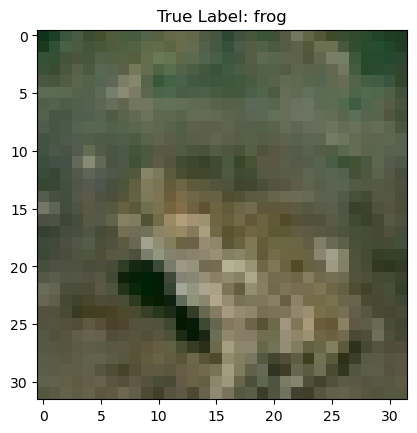

In [31]:
# Show a random image from the dataset

plot, index, label = show_random_image(train_data, mean=mean, std=std)

In [32]:
model = VGG_11(in_channels=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_configs['learning_rate'], momentum=best_configs['momentum'])

print(model)

VGG_11(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stri

In [33]:
model, configs, train_acc, val_acc, train_losses, val_losses = train(best_configs, train_loader, val_loader, criterion, optimizer, model, device)

test_accuracy = get_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy}')

Training the model...
---------------------
Epoch 1, Iteration 400/400, Loss: 1.2897256612777713
Epoch 1 done, Training Loss: 1.5509387038648128
Epoch 1, Validation Loss: 1.379219709634781
Epoch 1, Training Accuracy: 0.52785, Validation Accuracy: 0.5224 

Epoch 2, Iteration 400/400, Loss: 0.6768864989280701
Epoch 2 done, Training Loss: 1.0739452703297139
Epoch 2, Validation Loss: 0.9545514333248138
Epoch 2, Training Accuracy: 0.68905, Validation Accuracy: 0.6646 

Epoch 3, Iteration 400/400, Loss: 0.8389794826507568
Epoch 3 done, Training Loss: 0.855861095637083
Epoch 3, Validation Loss: 0.8184983569383621
Epoch 3, Training Accuracy: 0.756125, Validation Accuracy: 0.7198 

Epoch 4, Iteration 400/400, Loss: 0.67968040704727173
Epoch 4 done, Training Loss: 0.6967459101974964
Epoch 4, Validation Loss: 0.7468112534284592
Epoch 4, Training Accuracy: 0.7978, Validation Accuracy: 0.7484 

Epoch 5, Iteration 400/400, Loss: 0.47646436095237734
Epoch 5 done, Training Loss: 0.573146866708994
Epoc

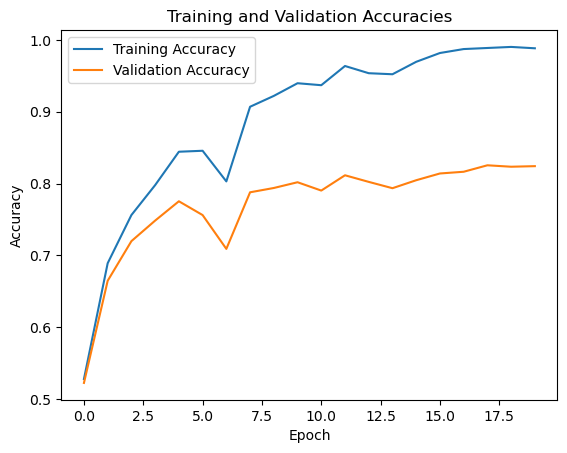

In [34]:
plot = plot_accuracies(train_acc, val_acc)
plt.show()

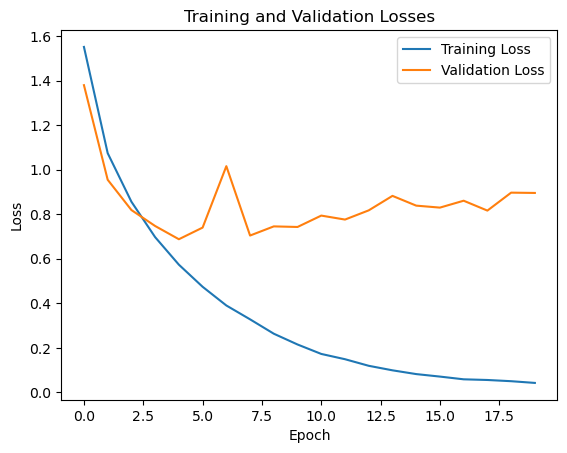

In [35]:
plot2 = plot_losses(train_losses, val_losses)
plt.show()

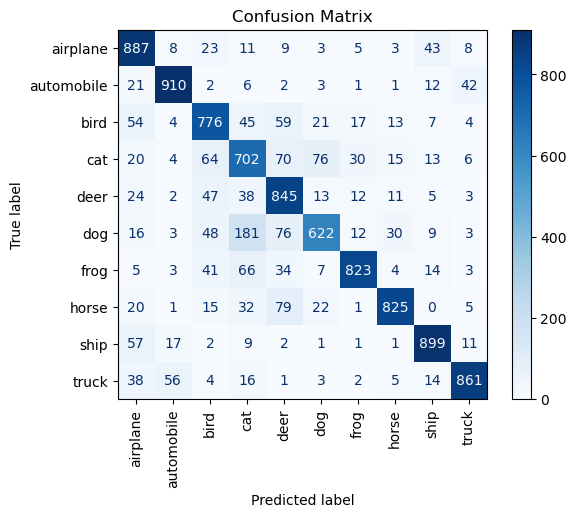

In [36]:
# Confusion Matrix

predicted_labels = get_predicted_labels(model, test_loader, device)
true_labels = test_data.targets

cm = confusion_matrix(true_labels, predicted_labels.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.title('Confusion Matrix')
plt.show()

True Label: bird
Predicted Label: bird


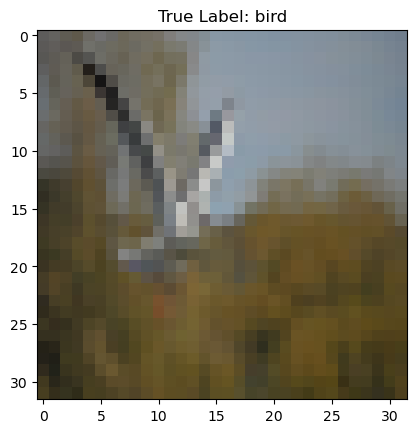

In [37]:
# Show an random image and its predicted label

plot, index, label = show_random_image(test_data, mean=mean, std=std)

predicted_label = predicted_labels[index].item()
print(f'True Label: {LABELS[label]}')
print(f'Predicted Label: {LABELS[predicted_label]}')

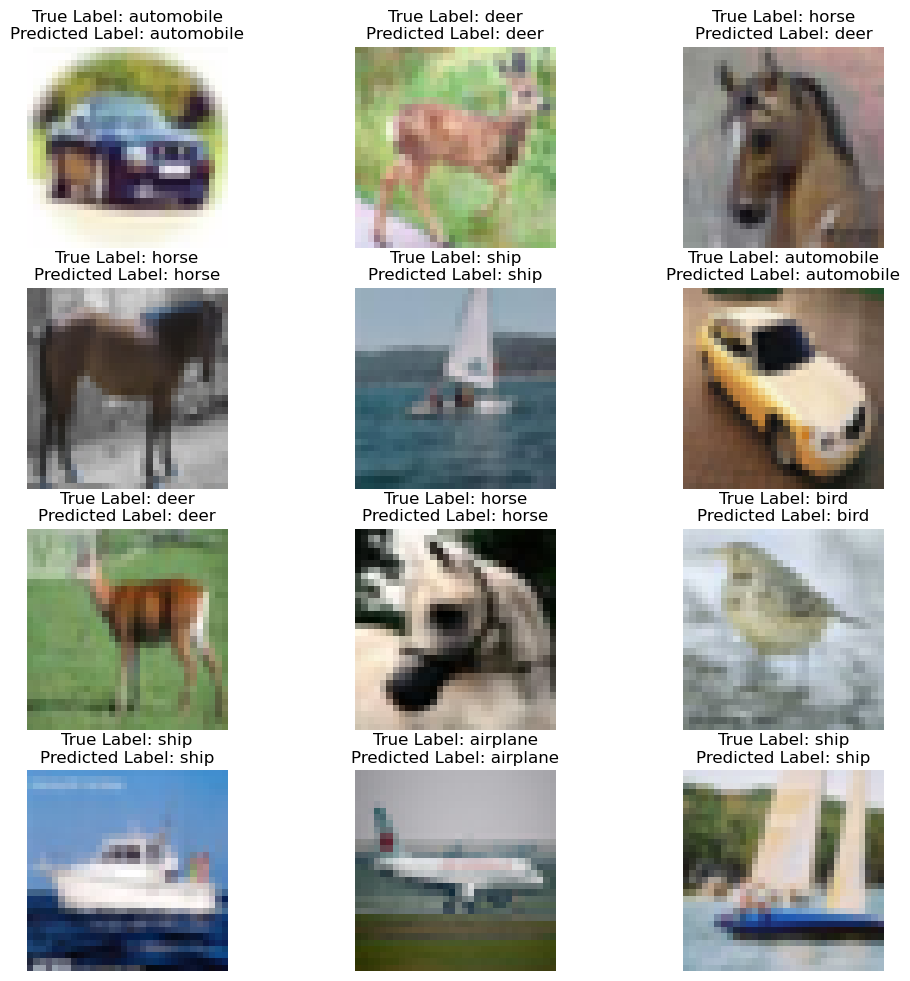

In [38]:
# Take a random 10 images and show their true and predicted labels in a 5*2 grid

fig, ax = plt.subplots(4, 3, figsize=(12, 12))
axes = ax.flatten()

for i in range(12):
    plot, index, label = show_random_image(test_data, mean=mean, std=std)
    predicted_label = predicted_labels[index].item()
    axes[i].set_title(f'True Label: {LABELS[label]}\nPredicted Label: {LABELS[predicted_label]}')
    axes[i].axis('off')
    axes[i].imshow(plot.get_array().clip(0, 1))